## Multi-Agent Deep Deterministic Policy Gradient (MADDPD)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers

Here we define initial parameters for exchange of Peer-to-Peer Energy Trading.  

**n_agents**: The number of agents or Prosumers in the environment, which is 3 in this case.

**n_actions**: The number of actions that each agent can take. In this case, it is 1, representing the power output of the battery.

**n_states**: The number of states in the environment. Here, it is 3, representing renewable generation, consumption, and battery charge status.

**G_p**: Renewable generation of each agent at each time step. It is a 3x5 matrix representing the renewable generation values for each agent over 5 time steps.

**D_p**: Consumption load of each agent at each time step. Similar to G_p, it is a 3x5 matrix representing the consumption load values for each agent over 5 time steps.

**E_batt**: Battery capacity of each agent.

**etta**: Battery efficiency for each agent.

**SoC_min**: Minimum State of Charge (SoC) allowed for each agent's battery.

**SoC_max**: Maximum State of Charge (SoC) allowed for each agent's battery.

**SoC_init**: Initial State of Charge (SoC) for each agent's battery.

**P_batt_min**: Minimum allowable battery power for each agent.

**P_batt_max**: Maximum allowable battery power for each agent.

**landa_b**: Buying price of electricity from the grid.

**landa_s**: Selling price of electricity to the grid.

**landa**: Penalty price for imbalance.

In [ ]:
# definition of env and model parameters
n_agents = 3               #(Prosumer) = 3
n_actions = 1              #  action = 1
n_states = 3               #  state = 3

# model and env's parameters
G_p = np.array([[1.0, 0.9, 0.93, 0.96, 0.94],
                [1.0, 0.9, 0.93, 0.96, 0.94],
                [1.0, 0.9, 0.93, 0.96, 0.94]])
D_p = np.array([[1.3, 1.2, 1.06, 1.0, 1.0],
                [1.3, 1.2, 1.06, 1.0, 1.0],
                [1.3, 1.2, 1.06, 1.0, 1.0]])
E_batt = np.array([13.5, 13.5, 13.5])
etta = np.array([0.925, 0.925, 0.925])
SoC_min = np.array([0.2, 0.2, 0.2])
SoC_max = np.array([0.8, 0.8, 0.8])
SoC_init = np.array([0.5, 0.5, 0.5])
P_batt_min = np.array([-5, -5, -5])
P_batt_max = np.array([5, 5, 5])

landa_b = 0.05
landa_s = 0.03
landa = 0.01


In [ ]:
# defining computational function

def calc_SDR(states, actions, D_p):
    total_generation = np.sum(states[:, 0] + actions)
    total_demand = np.sum(D_p)
    return total_generation / total_demand


def calc_prices(SDR):                             # price calculation based on SDR
    if SDR < 1.0:
        pi_b = (landa_s + landa) * landa_b / ((landa_b - landa_s - landa) * SDR + landa_s + landa)
        pi_s = pi_b * SDR + landa_b * (1 - SDR)
    else:
        pi_s = landa_s + landa
        pi_b = pi_s / SDR
    return pi_b, pi_s

**Neural network, Actor model**  
Here we implement the neural network model. It consists of 3 dense layer with 3 hidden layer `(2 relu + 1 tanh)`.

In [ ]:
# تعریف مدل شبکه‌های عصبی
def build_actor_model():                                  # actor network definition with dense layers
    model = tf.keras.Sequential([
        layers.Input(shape=(n_states,)),
        layers.Dense(300, activation='relu'),
        layers.Dense(300, activation='relu'),
        layers.Dense(300, activation='relu'),
        layers.Dense(n_actions, activation='sigmoid'
                     )
    ])
    return model


 **Critic model**   
 This critic model takes both states and actions as inputs and outputs a single value representing the estimated value (or Q-value) of that state-action pair.  
 **`Q-value`** is one of the most important parameters in Reinforecment Learning

In [ ]:
def build_critic_model():                                 # critic network definition with two inputs
    state_input = layers.Input(shape=(n_states,))
    action_input = layers.Input(shape=(n_actions,))

    state_net = layers.Dense(700, activation='relu')(state_input)
    action_net = layers.Dense(200, activation='relu')(action_input)

    merged = layers.Concatenate()([state_net, action_net])
    merged = layers.Dense(700, activation='relu')(merged)
    value_output = layers.Dense(1, activation='linear')(merged)

    model = tf.keras.Model(inputs=[state_input, action_input], outputs=value_output)

    return model

In [ ]:

# MADDPAG related funtions definition
class MADDPGAgent:
    def __init__(self):
        self.actor_model = build_actor_model()                              # building actor netwrork to predict action of agents
        self.critic_model = build_critic_model()                             # building critic netwrork to predict the rewrads
        self.target_actor_model = build_actor_model()
        self.target_critic_model = build_critic_model()

        self.target_actor_model.set_weights(self.actor_model.get_weights())
        self.target_critic_model.set_weights(self.critic_model.get_weights())

        self.actor_optimizer = optimizers.Adam(learning_rate=0.00009)
        self.critic_optimizer = optimizers.Adam(learning_rate=0.00001)

    def get_action(self, state):
        action = self.actor_model.predict(state.reshape(1, -1))[0]
        return action

    def train(self, states, actions, rewards, next_states, state_dim, action_dim, gamma=0.95): # agents training
        states = np.array(states).reshape(-1, state_dim)
        actions = np.array(actions).reshape(-1, action_dim)
        rewards = np.array(rewards)
        next_states = np.array(next_states).reshape(-1, state_dim)



        next_actions = self.target_actor_model.predict(next_states)
        next_q_values = self.target_critic_model.predict([next_states, next_actions])
        q_values = self.critic_model.predict([states, actions])

        target_q_values = rewards + gamma * next_q_values
        td_errors = target_q_values - q_values

        self.critic_optimizer.minimize(
            lambda: tf.keras.losses.mean_squared_error(target_q_values, self.critic_model([states, actions])),
            var_list=self.critic_model.trainable_variables
        )

        self.actor_optimizer.minimize(
            lambda: -tf.reduce_mean(self.critic_model([states, self.actor_model(states)])),
            var_list=self.actor_model.trainable_variables
        )

        self.update_target_networks()

    def update_target_networks(self, tau=0.001):
        actor_weights = self.actor_model.get_weights()
        critic_weights = self.critic_model.get_weights()
        target_actor_weights = self.target_actor_model.get_weights()
        target_critic_weights = self.target_critic_model.get_weights()

        for i in range(len(actor_weights)):
            target_actor_weights[i] = tau * actor_weights[i] + (1 - tau) * target_actor_weights[i]

        for i in range(len(critic_weights)):
            target_critic_weights[i] = tau * critic_weights[i] + (1 - tau) * target_critic_weights[i]

        self.target_actor_model.set_weights(target_actor_weights)
        self.target_critic_model.set_weights(target_critic_weights)


Here we can see the agents using `MADDPGAgent` class

In [ ]:
mgddp = MADDPGAgent()
agent = [mgddp for _ in range(n_agents)]
agent

In [ ]:
# Environment definition
class EnergyMarketEnv:
    def __init__(self):
        self.state = np.zeros((n_agents, n_states))
        self.agents = [MADDPGAgent() for _ in range(n_agents)]

    def reset(self):
        self.state[:, 0] = G_p[:, 0]
        self.state[:, 1] = D_p[:, 0]
        self.state[:, 2] = SoC_init

    def step(self, actions):
        for p in range(n_agents):
            P_net = D_p[p, 0] - (self.state[p, 0] + actions[p])
            self.state[p, 0] = G_p[p, 0]
            self.state[p, 1] = D_p[p, 0]
            self.state[p, 2] += etta[p] * (actions[p] / E_batt[p])
            self.state[p, 2] = np.clip(self.state[p, 2], SoC_min[p], SoC_max[p])

        SDR = calc_SDR(self.state, actions, D_p)
        pi_b, pi_s = calc_prices(SDR)

        P_grid = np.sum(D_p[:, 0] - (env.state[:, 0] + actions))

        if P_net>0:
          pi=pi_b
        else:
          pi=pi_s

        if P_grid > 0:
            landa_grid = landa_b
        else:
            landa_grid = landa_s

        #reward = -((pi * ((D_p[p, 0] - (self.state[p, 0] + actions[p])) - P_grid / n_agents)) + landa_grid * (P_grid / n_agents))
        rewards = [-((pi * ((D_p[p, 0] - (self.state[p, 0] + actions[p])) - P_grid / n_agents)) + landa_grid * (P_grid / n_agents)) for p in range(n_agents)] #rewards

        for p in range(n_agents):
            other_agents_actions = [agents.get_action(self.state[i]) for i, agents in enumerate(self.agents) if i != p]
            self.agents[p].train(self.state[p], actions[p], rewards[p], np.array(self.state[p]), 3, 1, gamma=0.95)


        next_state = np.copy(self.state)
        return next_state, rewards


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 61ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
Episode: 537, Total Reward: [0.0199517], Mean Reward (Last 10): 0.019952137023210526
1/1 [==============================] - 0s 27ms/step
Episode: 538, Total Reward: [0.01995271], Mean Reward (Last 10): 0.01995229721069336
1/1 [==============================] - 0s 22ms/step
Episode: 539, Total Reward: [0.01995419], Mean Reward (Last 10): 0.01995261386036873
1/1 [==============================] - 0s 24ms/step
Episode: 540, Total Reward: [0.01995401], Mean Reward (Last 10): 0.019952859729528427
1/1 [==============================] - 0s 20ms/step
Episode: 541, Total Reward: [0.01995231], Mean Reward (Last 10): 0.01995282992720604
1/1 [==============================] - 0s 19ms/step
Episode: 542, Total Reward: [0.01995137], Mean Reward (Last 10): 0.019952552393078804
1/1 [==============================] - 0s 39ms/step
Episode: 543, Total Reward: [0.01995113], Mean Reward (Last 10): 0.019952

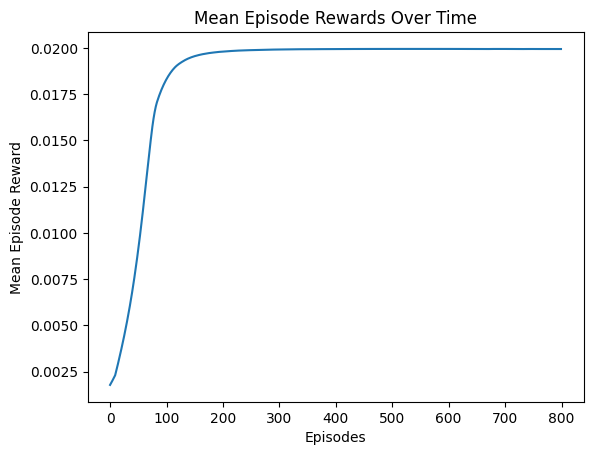

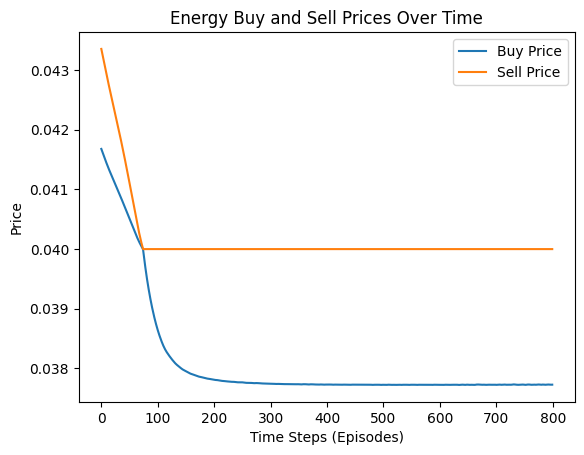

In [ ]:

n_episodes = 800
env = EnergyMarketEnv()

episode_rewards = []
mean_rewards = []

buy_prices = []
sell_prices = []
time_steps = []

for episode in range(n_episodes):
    env.reset()
    total_reward = 0

    actions = [agents.get_action(env.state[i]) for i, agents in enumerate(env.agents)]
    next_state, rewards = env.step(actions)
    total_reward += sum(rewards)
    env.state = next_state

    episode_rewards.append(total_reward)
    mean_reward = np.mean(episode_rewards[-10:])
    mean_rewards.append(mean_reward)

    SDR = calc_SDR(env.state, actions, D_p)
    pi_b, pi_s = calc_prices(SDR)
    buy_prices.append(pi_b)
    sell_prices.append(pi_s)
    time_steps.append(episode)

    print(f"Episode: {episode+1}, Total Reward: {total_reward}, Mean Reward (Last 10): {mean_reward}")

plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Mean Episode Reward')
plt.title('Mean Episode Rewards Over Time')
plt.show()

plt.plot(time_steps, buy_prices, label='Buy Price')
plt.plot(time_steps, sell_prices, label='Sell Price')
plt.xlabel('Time Steps (Episodes)')
plt.ylabel('Price')
plt.title('Energy Buy and Sell Prices Over Time')
plt.legend()
plt.show()
